## Natural Language Processing of Congressional Bills and Resolutions
### Group Members: James Midkiff, Michelle Orden, Kelly Yang
'Congressional Bill Visualizations.ipynb' Code Author: James Midkiff

### Data Preparation

In [18]:
import boto3
import pandas as pd
from plotnine import *
from io import StringIO

In [ ]:
# Copy Credentials Values and paste directly into input one at a time
credentials={}
credentials['aws_access_key_id']=input()
credentials['aws_secret_access_key']=input()
credentials['aws_session_token'] = input()

In [42]:
s3 = boto3.client('s3',
    region_name='us-east-1',
    aws_access_key_id=credentials['aws_access_key_id'],
    aws_secret_access_key=credentials['aws_secret_access_key'], 
    aws_session_token=credentials['aws_session_token'])
data = s3.get_object(Bucket="macs30123-bills", Key="data_bills.csv")['Body'].read()
# Little help from Kelly Yang with the following lines
data = data.decode('utf-8')
data = pd.read_csv(StringIO(data), index_col=0)
data

,session,type,outcome,sponsor_count,section_count,word_count,subjectivity,polarity
BILLS-113hr1000ih,113,hr,ih,1,10,5828,0.365513,0.065257
BILLS-113hr1001ih,113,hr,ih,3,1,482,0.416060,0.089283
BILLS-113hr1002ih,113,hr,ih,8,4,914,0.738466,0.374141
BILLS-113hr1003ih,113,hr,ih,5,1,304,0.448529,-0.031863
BILLS-113hr1004ih,113,hr,ih,5,5,2407,0.280459,0.088030
...,...,...,...,...,...,...,...,...
BILLS-116sconres7enr,116,sconres,enr,0,1,287,0.261458,-0.041667
BILLS-116sconres7es,116,sconres,es,0,1,285,0.298810,-0.047619
BILLS-116sconres7rfh,116,sconres,rfh,0,1,288,0.298810,-0.047619
BILLS-116sconres8is,116,sconres,is,2,1,96,0.185714,-0.030952


In [43]:
# Restricting only to house and senate bills, i.e. no resolutions
data = data[data['type'].isin(['hr', 's'])] 

In [78]:
data.drop(columns='Final Outcome', inplace=True)

In [81]:
data.loc[data['outcome']=='enr','Final Outcome'] = data.loc[data['outcome']=='enr','outcome'].replace('enr', 'Passed By Congress')
data.loc[data['outcome']!='enr','Final Outcome'] = data.loc[data['outcome']!='enr','outcome'].replace('^.*$', 'Not Passed By Congress', regex=True)
data = data.loc[~data['Final Outcome'].isna(),:]
data.groupby(['outcome', 'Final Outcome'])['Final Outcome'].count()

outcome  Final Outcome         
cds      Not Passed By Congress        1
cps      Not Passed By Congress       75
eah      Not Passed By Congress      123
eas      Not Passed By Congress      204
eh       Not Passed By Congress     3110
enr      Passed By Congress         1361
es       Not Passed By Congress      868
ih       Not Passed By Congress    28726
ips      Not Passed By Congress        1
is       Not Passed By Congress    15040
pap      Not Passed By Congress        4
pcs      Not Passed By Congress      611
pp       Not Passed By Congress        4
rcs      Not Passed By Congress       23
rds      Not Passed By Congress      535
rfh      Not Passed By Congress      392
rfs      Not Passed By Congress     2342
rh       Not Passed By Congress     2684
rs       Not Passed By Congress     1892
rts      Not Passed By Congress        3
Name: Final Outcome, dtype: int64

In [61]:
data.groupby('outcome')['Final Outcome'].count()

outcome
cds        1
cps       75
eah      123
eas      204
eh      3110
enr     1361
es       868
ih     28726
ips        1
is     15040
pap        4
pcs      611
pp         4
rcs       23
rds      535
rfh      392
rfs     2342
rh      2684
rs      1892
rts        3
Name: final_outcome, dtype: int64

### Total Bill Versions by Congressional Session

In [113]:
viz1 = (data.groupby(['type', 'Final Outcome', 'session'])['outcome']
    .count().to_frame(name='count').reset_index().sort_values('session'))
viz1 = viz1.join(viz1.groupby(['type', 'session']).sum(), on=['type', 'session'], rsuffix='_total')
viz1['Proportion'] = viz1['count'] / viz1['count_total']
viz1

,type,Final Outcome,session,count,count_total,Proportion
0,hr,Not Passed By Congress,113,7624,7831,0.973567
4,hr,Passed By Congress,113,207,7831,0.026433
8,s,Not Passed By Congress,113,3575,3648,0.979989
12,s,Passed By Congress,113,73,3648,0.020011
1,hr,Not Passed By Congress,114,8910,9129,0.976011
5,hr,Passed By Congress,114,219,9129,0.023989
9,s,Not Passed By Congress,114,4301,4412,0.974841
13,s,Passed By Congress,114,111,4412,0.025159
2,hr,Not Passed By Congress,115,10437,10721,0.973510
6,hr,Passed By Congress,115,284,10721,0.026490


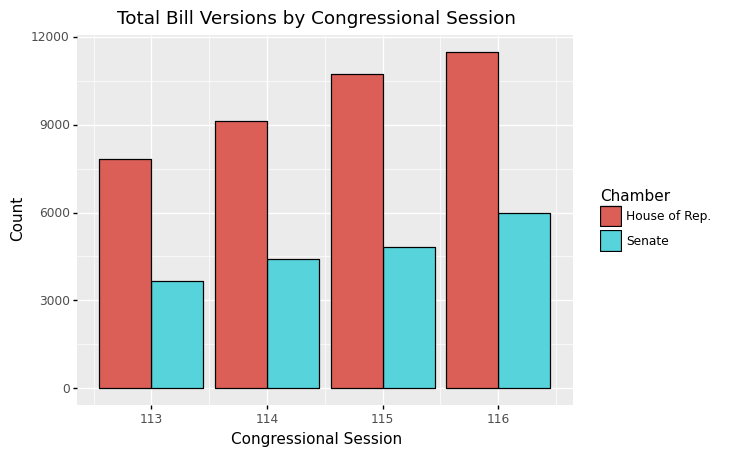

In [253]:
viz=viz1.groupby(['type', 'session'])['count'].sum().to_frame().reset_index()
g = (ggplot(viz, aes(x='session', y='count', fill='type')) + 
    geom_col(color='black', position='dodge') + 
    labs(title='Total Bill Versions by Congressional Session', x='Congressional Session', 
         y='Count', fill='Chamber') + 
    scale_fill_discrete(labels=['House of Rep.', 'Senate']))
g.draw()
g.save(filename='Images/total_versions.png', width=7, height=5, verbose=False)

### Proportion of Bill Versions Passed by Congress

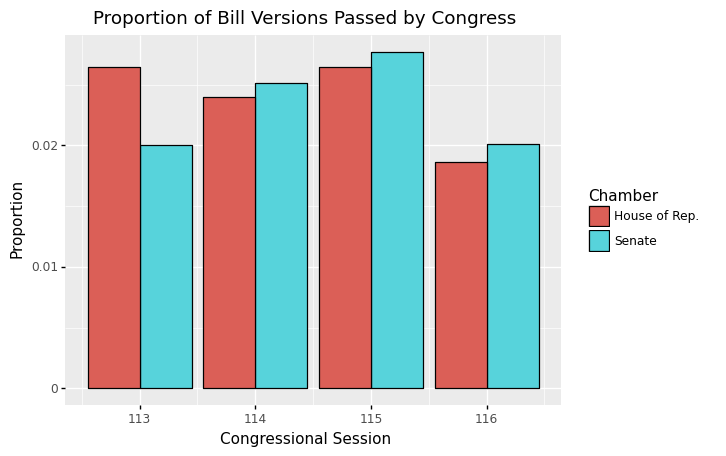

In [254]:
viz=viz1.loc[viz1['Final Outcome'] =='Passed By Congress', :]
g = (ggplot(viz, aes(x='session', y='Proportion', fill='type')) + 
    geom_col(color='black', position='dodge') + 
    labs(title='Proportion of Bill Versions Passed by Congress', x='Congressional Session', 
         y='Proportion', fill='Chamber') + 
    scale_fill_discrete(labels=['House of Rep.', 'Senate']))
g.draw()
g.save(filename='Images/proportion_passed.png', width=7, height=5, verbose=False)

In [249]:
pwd

'D:\\Everything\\UChicago\\Fall 2021\\MACS 30123\\Project'

In [256]:
viz=data.groupby('Final Outcome')['word_count'].describe(
    percentiles=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.98])[
    ['10%', '20%', '30%', '40%', '50%', '60%', '70%', '80%', '90%', '95%', '98%']]
viz=viz.melt(var_name='Metric', ignore_index=False).reset_index()
viz

,Final Outcome,Metric,value
0,Not Passed By Congress,10%,138.00
1,Passed By Congress,10%,119.00
2,Not Passed By Congress,20%,225.00
3,Passed By Congress,20%,126.00
4,Not Passed By Congress,30%,335.00
5,Passed By Congress,30%,160.00
6,Not Passed By Congress,40%,462.00
7,Passed By Congress,40%,257.00
8,Not Passed By Congress,50%,641.00
9,Passed By Congress,50%,421.00


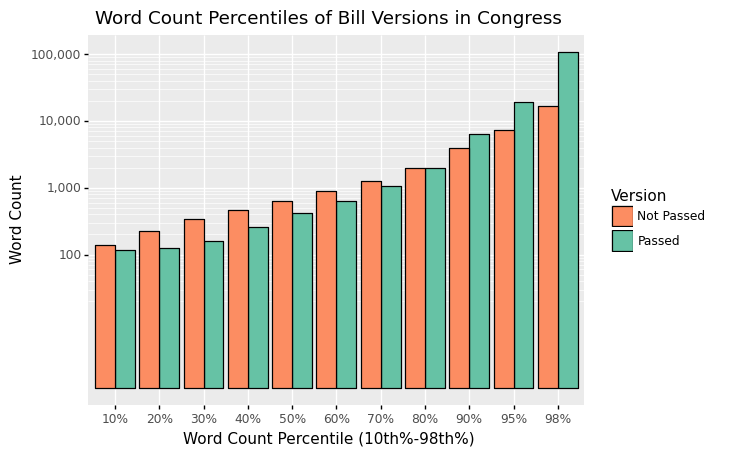

In [258]:
g = (ggplot(viz, aes(x='Metric', y='value', fill='Final Outcome')) + 
    geom_col(color='black', position='dodge', na_rm=False) + 
    labs(title='Word Count Percentiles of Bill Versions in Congress', 
         x='Word Count Percentile (10th%-98th%)', 
         y='Word Count', fill='Version') + 
    scale_fill_brewer(labels=['Not Passed', 'Passed'], 
                      type='qual', palette='Set2', direction=-1) + 
    scale_y_log10(breaks=[100, 1000, 10000, 100000], 
                  labels=['100', '1,000', '10,000', '100,000']))
g.draw()
g.save(filename='Images/word_count_percentiles.png', width=7, height=5, verbose=False)

In [233]:
data.loc[data['outcome']=='enr','Binary Outcome'] = data.loc[data['outcome']=='enr','outcome'].replace('enr', 1)
data.loc[data['outcome']!='enr','Binary Outcome'] = data.loc[data['outcome']!='enr','outcome'].replace('^.*$', 0, regex=True)
corr = data[['sponsor_count', 'section_count', 'word_count', 'subjectivity', 'polarity', 'Binary Outcome']].corr()
corr

,sponsor_count,section_count,word_count,subjectivity,polarity,Binary Outcome
sponsor_count,1.000000,0.017873,0.028427,0.040340,0.020914,-0.057074
section_count,0.017873,1.000000,0.934134,0.049266,0.015740,0.057347
word_count,0.028427,0.934134,1.000000,0.054549,0.014235,0.057328
subjectivity,0.040340,0.049266,0.054549,1.000000,0.331269,-0.060514
polarity,0.020914,0.015740,0.014235,0.331269,1.000000,0.014080
Binary Outcome,-0.057074,0.057347,0.057328,-0.060514,0.014080,1.000000


In [235]:
import numpy as np
corr = corr.melt(ignore_index=False)
corr.rename(columns={'variable': 'Variable', 'value': 'Value'}, inplace=True)
corr.reset_index(inplace=True)
corr.sort_values(by=['index', 'Variable'], ascending=[True, False], inplace=True)
corr['Value'] = corr['Value'].round(3)
corr['Text'] = corr['Value']
corr['Value'] = corr['Value'].mask(corr['Value'] == 1.0, np.nan)
corr = corr.replace(to_replace={
    'Binary Outcome': 'Passage', 'word_count': 'Word Count', 
    'subjectivity': 'Subjectivity', 'sponsor_count': 'Sponsor Count', 
    'section_count': 'Section Count', 'polarity': 'Polarity'})
corr.head(10)

,index,Variable,Value,Text
17,Passage,Word Count,0.057,0.057
23,Passage,Subjectivity,-0.061,-0.061
5,Passage,Sponsor Count,-0.057,-0.057
11,Passage,Section Count,0.057,0.057
29,Passage,Polarity,0.014,0.014
35,Passage,Passage,NaN,1.000
16,Polarity,Word Count,0.014,0.014
22,Polarity,Subjectivity,0.331,0.331
4,Polarity,Sponsor Count,0.021,0.021
10,Polarity,Section Count,0.016,0.016


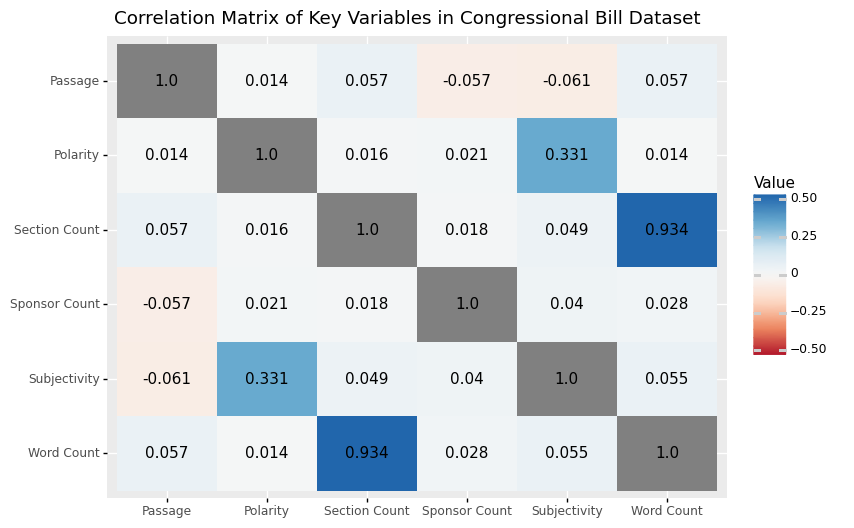

In [259]:
order = ['Word Count', 'Subjectivity', 'Sponsor Count', 'Section Count', 'Polarity', 'Passage']
g = (ggplot(corr, aes(x='index', y='Variable', fill='Value')) + 
    geom_tile() + 
    scale_y_discrete(limits=order) + 
    labs(title='Correlation Matrix of Key Variables in Congressional Bill Dataset', y='', x='') + 
    scale_fill_distiller(type='div', palette='RdBu', limits=[-0.5,0.5], na_value='grey', direction=1) + 
    geom_text(aes(label='Text')) + 
    theme(figure_size=(8, 6)))
g.draw()
g.save(filename='Images/correlation.png', width=7, height=5, verbose=False)